In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.conv1 = nn.Conv1d(20, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv1d(20, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv1d(64, 20, kernel_size=3, stride=1, padding=1, bias=False)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, h_reshaped, encoder_states):
        x = encoder_states
        x = x.transpose(0,1)
        h_reshaped = h_reshaped.transpose(0,1)
        x = self.conv1(x)
        h_reshaped = self.conv2(h_reshaped)
        attention_input = torch.cat((h_reshaped, x), dim=2)
        
        b, c, _ = attention_input.size()
        y = self.avg_pool(attention_input).view(b, c)
        y = self.fc(y).view(b, c, 1)
        output = x * y.expand_as(x)
        output = self.conv3(output)
        output = output.transpose(0,1)
        return output

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(x)
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [4]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers)

        self.attention = SELayer(64,16)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, encoder_states, hidden, cell):

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        context_vector = self.attention(h_reshaped, encoder_states)

        rnn_input = context_vector
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(20*22, 1)

    def forward(self, source, teacher_force_ratio=0.5):
        source = source.transpose(0,1)
        batch_size = source.shape[1]
        target_len = source.shape[0]
        target_vocab_size = 22

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # At every time step use encoder_states and update hidden, cell
        output, hidden, cell = self.decoder(encoder_states, hidden, cell)

        # Store prediction for current time step
        outputs = output
            
        outputs = outputs.transpose(0,1)
        outputs = self.flatten(outputs)
        outputs = self.final_layer(outputs)

        return outputs

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_net = Encoder(
    input_size=22,  
    hidden_size=32, 
    num_layers=1, 
    p=0
).to(device)

decoder_net = Decoder(
    input_size=22,
    hidden_size=32,
    output_size=22,
    num_layers=1,
    p=0,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [7]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x,x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[-0.0609],
        [-0.0646],
        [-0.0581],
        [-0.0613],
        [-0.0649]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [10]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [11]:
df_for_training=df[feature_names].astype(float)

In [12]:
df_for_training.shape

(11524, 22)

In [13]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [14]:
trainX=[]
trainY=[]

In [15]:
n_future=1
n_past=20

In [16]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [17]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [18]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [19]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [20]:
data,label=random_shuffle(trainX,trainY)

In [21]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [23]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

Epoch: 0 Loss: 0.05197221785783768


D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 Loss: 0.10790286958217621
Epoch: 2 Loss: 0.04318125173449516
Epoch: 3 Loss: 0.031426772475242615
Epoch: 4 Loss: 0.20279794931411743
Epoch: 5 Loss: 0.11597488075494766
Epoch: 6 Loss: 0.04333805292844772
Epoch: 7 Loss: 0.07107523083686829
Epoch: 8 Loss: 0.18843737244606018
Epoch: 9 Loss: 0.06689533591270447
Epoch: 10 Loss: 0.02752557396888733
Epoch: 11 Loss: 0.021971233189105988
Epoch: 12 Loss: 0.04521075636148453
Epoch: 13 Loss: 0.08291611075401306
Epoch: 14 Loss: 0.015548989176750183
Epoch: 15 Loss: 0.0458081029355526
Epoch: 16 Loss: 0.05566362291574478
Epoch: 17 Loss: 0.03206939250230789
Epoch: 18 Loss: 0.02950940653681755
Epoch: 19 Loss: 0.05871379375457764
Epoch: 20 Loss: 0.07587013393640518
Epoch: 21 Loss: 0.08794818073511124
Epoch: 22 Loss: 0.06218820810317993
Epoch: 23 Loss: 0.017953261733055115
Epoch: 24 Loss: 0.0459977388381958
Epoch: 25 Loss: 0.027018776163458824
Epoch: 26 Loss: 0.047742851078510284
Epoch: 27 Loss: 0.03062620759010315
Epoch: 28 Loss: 0.045941263437271

Epoch: 222 Loss: 0.028645675629377365
Epoch: 223 Loss: 0.012402469292283058
Epoch: 224 Loss: 0.008917953819036484
Epoch: 225 Loss: 0.014380816370248795
Epoch: 226 Loss: 0.021357981488108635
Epoch: 227 Loss: 0.01769886165857315
Epoch: 228 Loss: 0.0071283127181231976
Epoch: 229 Loss: 0.014731626957654953
Epoch: 230 Loss: 0.0061470093205571175
Epoch: 231 Loss: 0.06166306138038635
Epoch: 232 Loss: 0.008415378630161285
Epoch: 233 Loss: 0.012585739605128765
Epoch: 234 Loss: 0.010708780027925968
Epoch: 235 Loss: 0.010734776966273785
Epoch: 236 Loss: 0.006779300980269909
Epoch: 237 Loss: 0.023736150935292244
Epoch: 238 Loss: 0.01546633243560791
Epoch: 239 Loss: 0.003712947480380535
Epoch: 240 Loss: 0.009620578028261662
Epoch: 241 Loss: 0.011062780395150185
Epoch: 242 Loss: 0.004845494404435158
Epoch: 243 Loss: 0.022423867136240005
Epoch: 244 Loss: 0.024991653859615326
Epoch: 245 Loss: 0.014665285125374794
Epoch: 246 Loss: 0.008241742849349976
Epoch: 247 Loss: 0.024857930839061737
Epoch: 248 Lo

Epoch: 439 Loss: 0.011591248214244843
Epoch: 440 Loss: 0.003612823784351349
Epoch: 441 Loss: 0.008871720172464848
Epoch: 442 Loss: 0.013208403252065182
Epoch: 443 Loss: 0.006833995692431927
Epoch: 444 Loss: 0.005412045866250992
Epoch: 445 Loss: 0.014163949526846409
Epoch: 446 Loss: 0.023046892136335373
Epoch: 447 Loss: 0.007443723268806934
Epoch: 448 Loss: 0.023162102326750755
Epoch: 449 Loss: 0.013514705933630466
Epoch: 450 Loss: 0.006385505199432373
Epoch: 451 Loss: 0.007649095728993416
Epoch: 452 Loss: 0.00372177641838789
Epoch: 453 Loss: 0.019593365490436554
Epoch: 454 Loss: 0.020262129604816437
Epoch: 455 Loss: 0.012894416227936745
Epoch: 456 Loss: 0.012003340758383274
Epoch: 457 Loss: 0.011588040739297867
Epoch: 458 Loss: 0.01406736671924591
Epoch: 459 Loss: 0.009923498146235943
Epoch: 460 Loss: 0.01207922026515007
Epoch: 461 Loss: 0.009238403290510178
Epoch: 462 Loss: 0.026280870661139488
Epoch: 463 Loss: 0.014472626149654388
Epoch: 464 Loss: 0.011712102219462395
Epoch: 465 Loss

Epoch: 656 Loss: 0.007283451966941357
Epoch: 657 Loss: 0.007814265787601471
Epoch: 658 Loss: 0.005217161029577255
Epoch: 659 Loss: 0.004269490018486977
Epoch: 660 Loss: 0.0034153214655816555
Epoch: 661 Loss: 0.02156214416027069
Epoch: 662 Loss: 0.004151899367570877
Epoch: 663 Loss: 0.00595892034471035
Epoch: 664 Loss: 0.02142312005162239
Epoch: 665 Loss: 0.015177298337221146
Epoch: 666 Loss: 0.005429033190011978
Epoch: 667 Loss: 0.0035915090702474117
Epoch: 668 Loss: 0.010066431015729904
Epoch: 669 Loss: 0.0071942005306482315
Epoch: 670 Loss: 0.006184435449540615
Epoch: 671 Loss: 0.0027224579825997353
Epoch: 672 Loss: 0.007715918123722076
Epoch: 673 Loss: 0.007599775679409504
Epoch: 674 Loss: 0.02653377130627632
Epoch: 675 Loss: 0.011590700596570969
Epoch: 676 Loss: 0.014259879477322102
Epoch: 677 Loss: 0.009150702506303787
Epoch: 678 Loss: 0.011432868428528309
Epoch: 679 Loss: 0.009143959730863571
Epoch: 680 Loss: 0.0041352370753884315
Epoch: 681 Loss: 0.007016288116574287
Epoch: 682 

Epoch: 872 Loss: 0.008078236132860184
Epoch: 873 Loss: 0.015551744028925896
Epoch: 874 Loss: 0.011228987947106361
Epoch: 875 Loss: 0.011789285577833652
Epoch: 876 Loss: 0.009436595253646374
Epoch: 877 Loss: 0.008987098932266235
Epoch: 878 Loss: 0.003908950369805098
Epoch: 879 Loss: 0.008732220157980919
Epoch: 880 Loss: 0.010842899791896343
Epoch: 881 Loss: 0.014008570462465286
Epoch: 882 Loss: 0.009629381820559502
Epoch: 883 Loss: 0.0055197663605213165
Epoch: 884 Loss: 0.01066051796078682
Epoch: 885 Loss: 0.0024174246937036514
Epoch: 886 Loss: 0.004903123714029789
Epoch: 887 Loss: 0.007981467060744762
Epoch: 888 Loss: 0.0032170088961720467
Epoch: 889 Loss: 0.01652456820011139
Epoch: 890 Loss: 0.013412418775260448
Epoch: 891 Loss: 0.015248139388859272
Epoch: 892 Loss: 0.004254945088177919
Epoch: 893 Loss: 0.005858074873685837
Epoch: 894 Loss: 0.0070180743932724
Epoch: 895 Loss: 0.006988320965319872
Epoch: 896 Loss: 0.0043964567594230175
Epoch: 897 Loss: 0.006239185109734535
Epoch: 898 L

In [24]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [25]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [26]:
predictions = np.array(predictions)

In [27]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [28]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

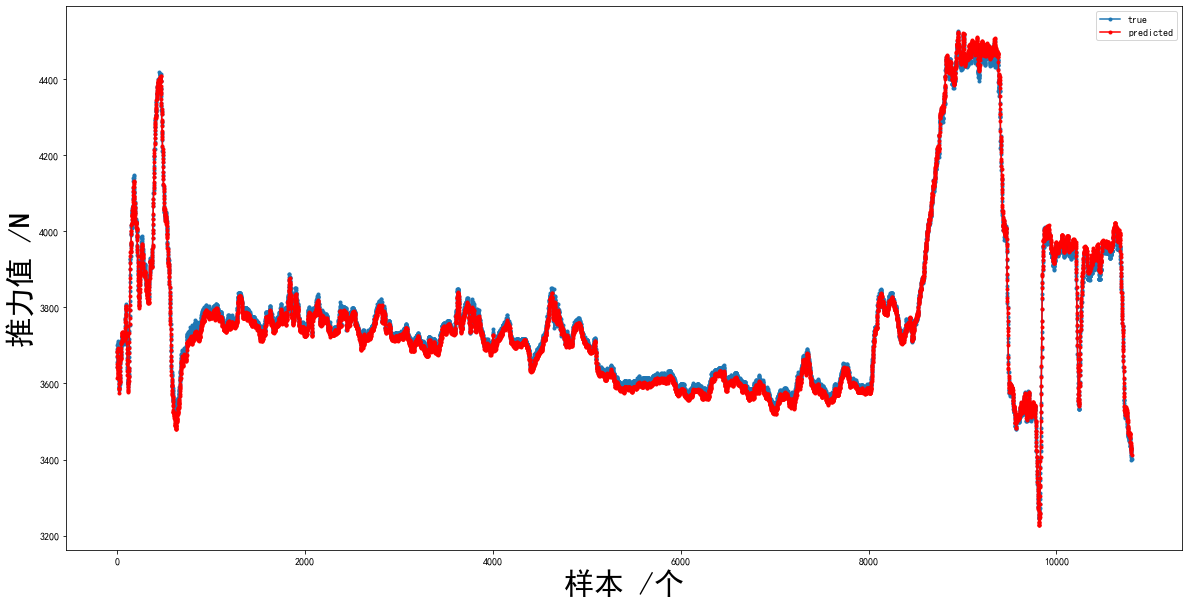

In [29]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();